<a href="https://colab.research.google.com/github/Jarvis-Geun/DeepLearning-Wiki/blob/main/XAI/SHAP_HTO/xgboost_treeshap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# xgboost model with SHAP

`-` Reference
- [Using SHAP Values to Explain How Your Machine Learning Model Works](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137)
- [SHAP Values.ipynb](https://github.com/vinyluis/Articles/blob/main/Boruta%20SHAP/SHAP%20Values.ipynb)
- [XGBoost 개념 이해](https://wooono.tistory.com/97)
- [SHAP latest documentation](https://shap-lrjball.readthedocs.io/en/latest/examples.html#tree-explainer-examples)

## 1. Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('default')

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [12]:
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 11.1 MB/s eta 0:00:00


## 2. Load dataset

In [13]:
from glob import glob
import pandas as pd

file_names = glob("*.xlsx")
# read xlsx format using pandas
# read only first index of the dataset
df = pd.read_excel(file_names[-1], engine="openpyxl")

In [14]:
file_names

['3rd validation HTO_modif_Missing data delete_For AI_Outcome 2.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 3.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 1.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 5.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI_Outcome 4.xlsx',
 '3rd validation HTO_modif_Missing data delete_For AI.xlsx']

In [15]:
df.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI,Outcome
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30,1
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.25,11.19,9.14,2.05,0,62,149,51,22.97,1
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,-0.83,8.04,5.65,2.39,0,53,148,68,31.04,1
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01,1
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-3.84,11.09,6.51,4.58,0,52,155,83,34.55,1


### Define X

In [16]:
X = df.iloc[:, :-1]
X.head(5)

,case no.,PreWBL,Pre\nJLCA,Pre\nMPTA,Pre\nLDFA,Pre Coronal translation),PostWBL,Post\nJLCA,Post\nMPTA,Post\nLDFA,...,∆LDFA,Delta Coronal translation,LJSW (Varus),MJSW (Valgus),VVD,"Sex (M:1, F:0)",Age,Height,Weight,BMI
0,1,19.726354,4.926667,85.856667,87.710000,3.71,67.400222,3.973333,95.550000,87.026667,...,-0.683333,-1.00,6.72,7.21,-0.49,0,52,152,70,30.30
1,2,10.615200,6.420000,85.100000,89.050000,6.71,61.882716,7.350000,95.910000,86.193333,...,-2.856667,-2.25,11.19,9.14,2.05,0,62,149,51,22.97
2,3,-5.870595,22.423333,81.133333,90.900000,6.61,25.177793,4.176667,89.660000,91.566667,...,0.666667,-0.83,8.04,5.65,2.39,0,53,148,68,31.04
3,4,31.436854,5.950000,86.766667,88.396667,8.28,58.257285,4.090000,91.866667,86.023333,...,-2.373333,-1.80,8.83,8.90,-0.07,1,61,169,80,28.01
4,5,22.523574,3.660000,87.806667,90.406667,6.39,54.622471,4.460000,93.120000,88.263333,...,-2.143333,-3.84,11.09,6.51,4.58,0,52,155,83,34.55


### Define y label

In [17]:
y = df.iloc[:, -1]
y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: Outcome, dtype: int64

In [18]:
X.shape, y.shape

((327, 24), (327,))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((261, 24), (66, 24), (261,), (66,))

## 3. Extreme Gradient Boosting (xgboost)

In [21]:
model = xgb.XGBClassifier()

In [22]:
model.fit(X_train, y_train)

XGBClassifier()

### 3.1 Evaluate the model

In [23]:
y_pred = model.predict(X_test)

In [24]:
# View accuracy score
accuracy_score(y_test, y_pred)

0.803030303030303

In [25]:
# View confusion matrix for test data and predictions
# sum of confusion matrix is equal to y_test.shape
confusion_matrix(y_test, y_pred)

array([[19,  5],
       [ 8, 34]])

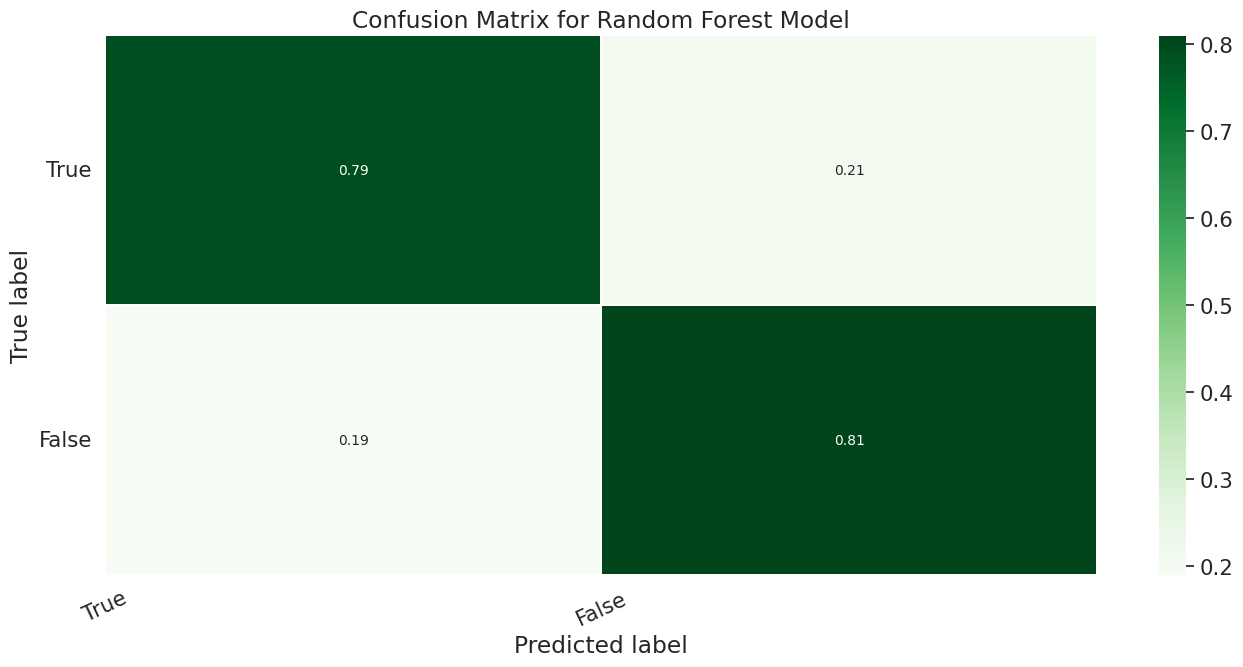

In [26]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['True', 'False']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [27]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.79      0.75        24
           1       0.87      0.81      0.84        42

    accuracy                           0.80        66
   macro avg       0.79      0.80      0.79        66
weighted avg       0.81      0.80      0.81        66



### 3.2 Visualize xgboost

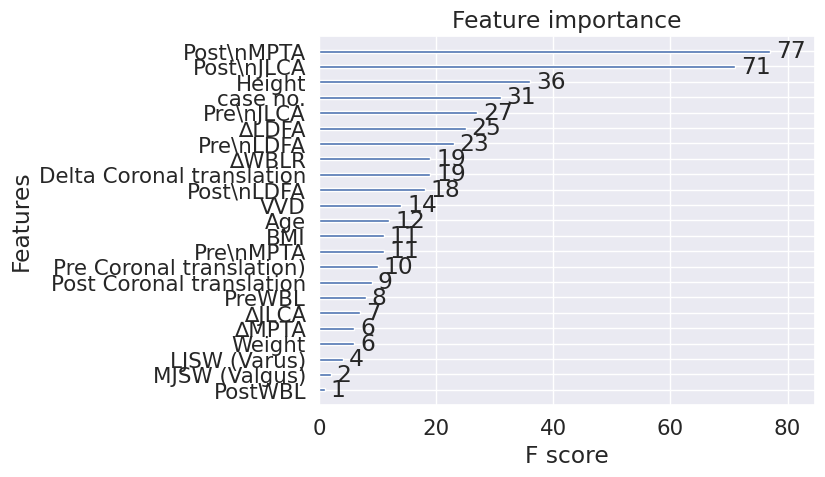

In [45]:
# 변수 중요도
xgb.plot_importance(model)

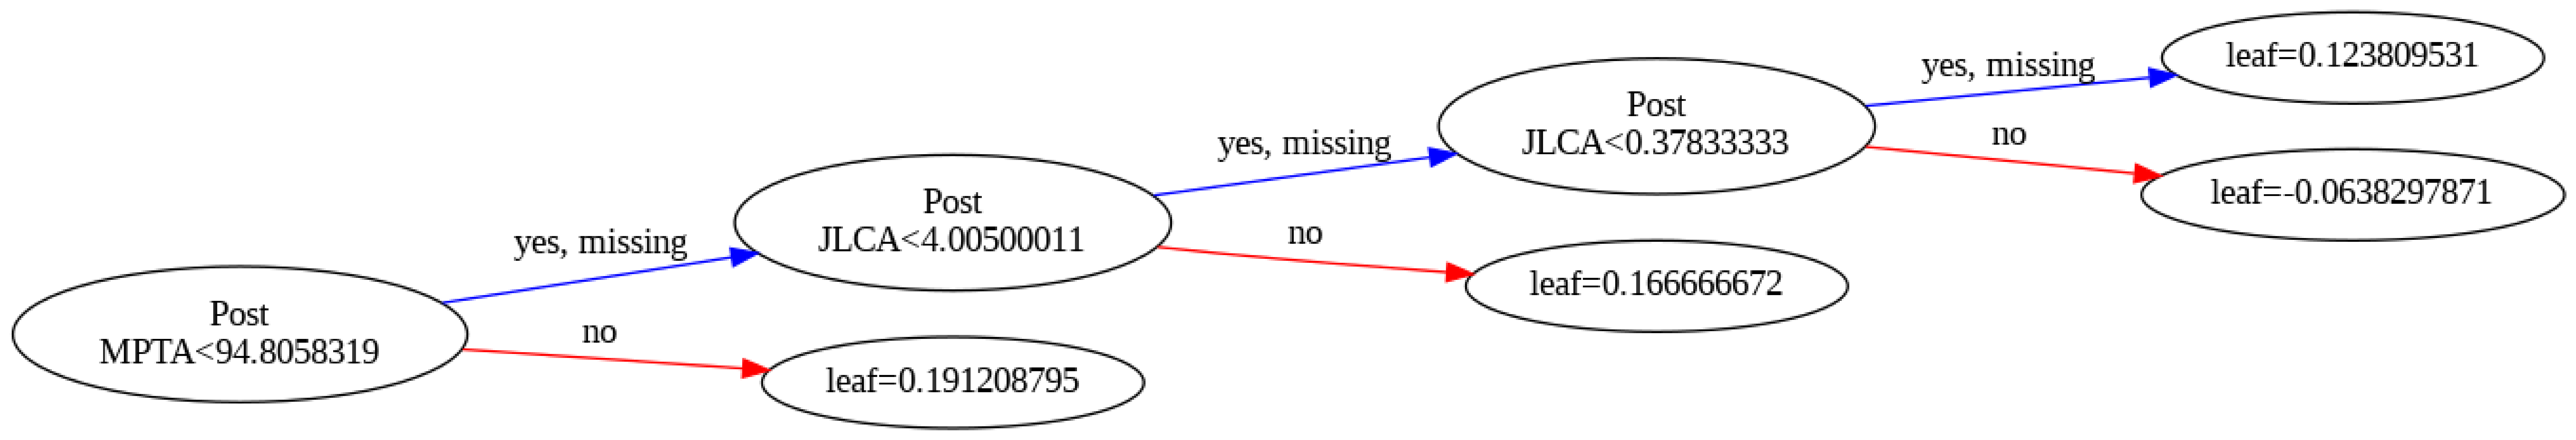

In [49]:
  """ 의사결정 트리 시각화 """
  # num_trees : 그림을 여러개 그릴시 그림 번호
  # rankdir : 트리의 방향, 디폴트는 위아래 방향
  # rankdir="LR" : 왼쪽에서 오른쪽 방향으로 트리를 보여준다.
  xgb.plot_tree(model, num_trees=0, rankdir='LR')

  fig = plt.gcf()
  fig.set_size_inches(150, 100)

  # 이미지 저장하고 싶다면
  # fig.savefig('tree.png')

  plt.show()

## 4. Visualization to compare Kernel SVM models

### 4.1 Define function

## 5. SHAP

In [54]:
import shap

In [58]:
# Fits the explainer
explainer = shap.TreeExplainer(model)
# Calculates the SHAP values - It takes some time
# shap_values variable (three attributes) : .values, .base_values, .data
shap_values = explainer(X_test)

In [59]:
from scipy.special import softmax
import numpy as np

def print_feature_importances_shap_values(shap_values, features):
  '''
  Prints the feature importances based on SHAP values in an ordered way shap_values
  -> The SHAP values calculated from a shap.Explainer object features
  -> The name of the features, on the order presented to the explainer
  '''
  # Calculates the feature importance (mean absolute shap value) for each feature
  importances = []
  for i in range(shap_values.values.shape[1]):
    importances.append(np.mean(np.abs(shap_values.values[:, i])))

  # Calculates the normalized version
  importances_norm = softmax(importances)

  # Organize the importances and columns in a dictionary
  feature_importances = {fea: imp for imp, fea in zip(importances, features)}
  feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}

  # Sorts the dictionary
  feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}
  feature_importances_norm = {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse=True)}
  
  # Prints the feature importances
  for k, v in feature_importances.items():
    print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

In [60]:
print_feature_importances_shap_values(shap_values, X_test.columns)

Post
MPTA -> 1.6777 (softmax = 0.1666)
Post
JLCA -> 0.8586 (softmax = 0.0734)
Pre
JLCA -> 0.2810 (softmax = 0.0412)
Pre
LDFA -> 0.2708 (softmax = 0.0408)
Height -> 0.2201 (softmax = 0.0388)
case no. -> 0.1799 (softmax = 0.0373)
Pre Coronal translation) -> 0.1585 (softmax = 0.0365)
∆WBLR -> 0.1440 (softmax = 0.0359)
Post
LDFA -> 0.1229 (softmax = 0.0352)
∆LDFA -> 0.1176 (softmax = 0.0350)
Delta Coronal translation -> 0.1144 (softmax = 0.0349)
Pre
MPTA -> 0.0895 (softmax = 0.0340)
Post Coronal translation -> 0.0786 (softmax = 0.0337)
Age -> 0.0775 (softmax = 0.0336)
∆MPTA -> 0.0754 (softmax = 0.0336)
PreWBL -> 0.0672 (softmax = 0.0333)
Weight -> 0.0563 (softmax = 0.0329)
VVD -> 0.0547 (softmax = 0.0329)
BMI -> 0.0342 (softmax = 0.0322)
∆JLCA -> 0.0268 (softmax = 0.0320)
PostWBL -> 0.0225 (softmax = 0.0318)
MJSW (Valgus) -> 0.0193 (softmax = 0.0317)
LJSW (Varus) -> 0.0178 (softmax = 0.0317)
Sex (M:1, F:0) -> 0.0000 (softmax = 0.0311)


### Bar plot

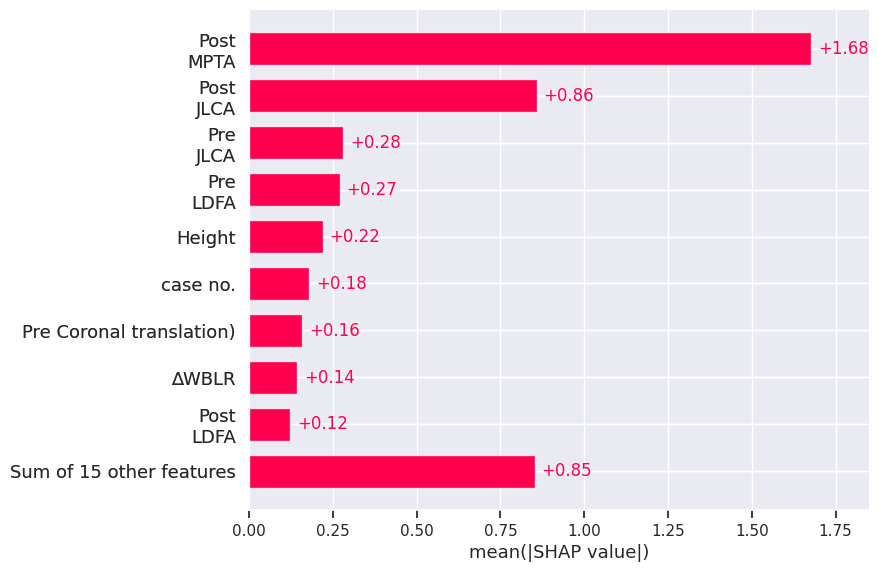

In [61]:
shap.plots.bar(shap_values)

### Summary plot: beeswarm

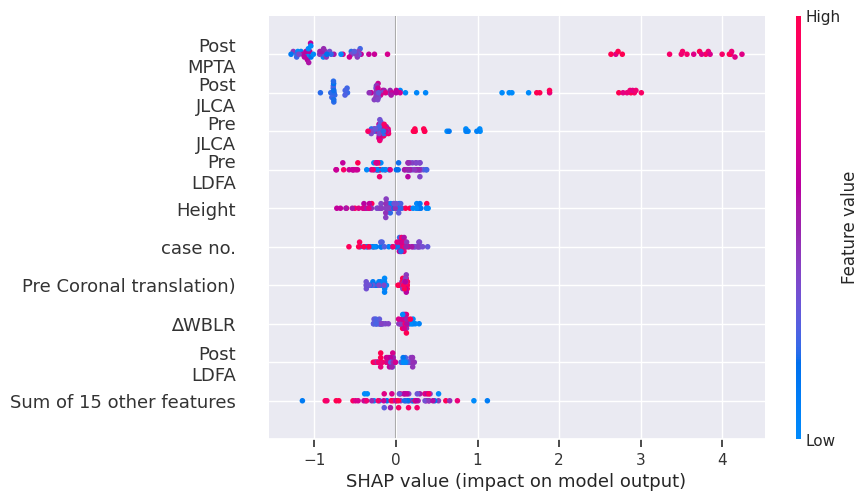

In [62]:
shap.plots.beeswarm(shap_values)

### Summary plot: violin

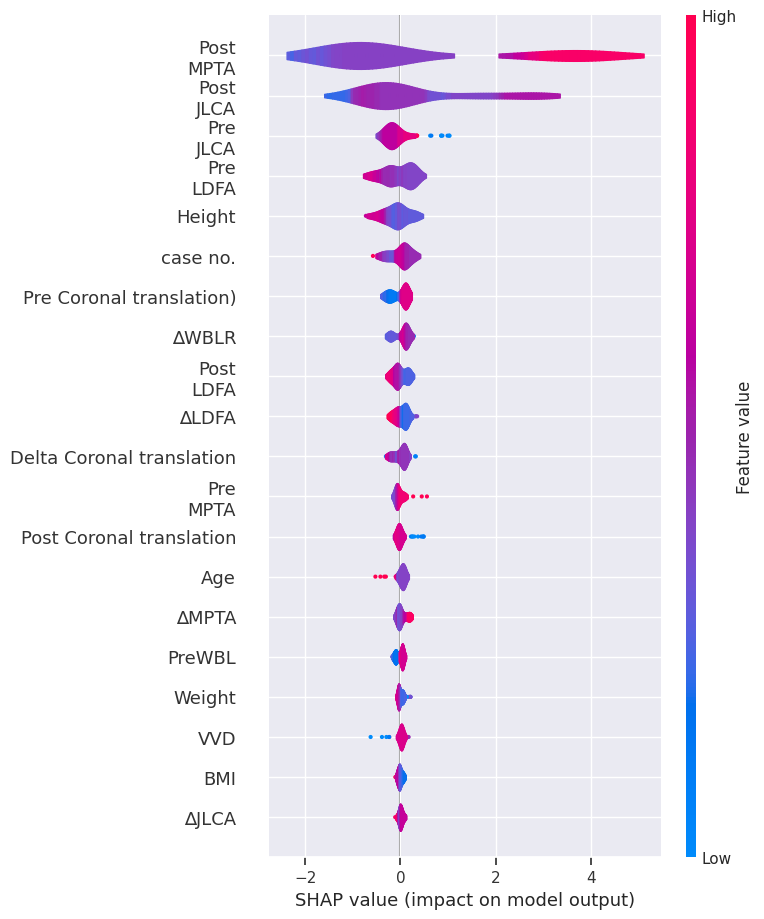

In [63]:
shap.summary_plot(shap_values, plot_type="violin")

### Local bar plot: single observation

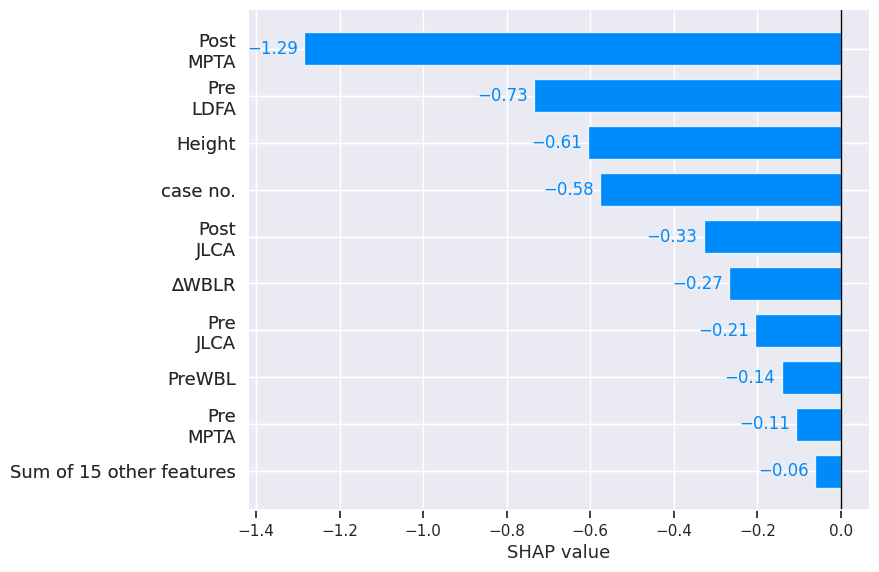

In [64]:
shap.plots.bar(shap_values[0])

### Waterfall plot

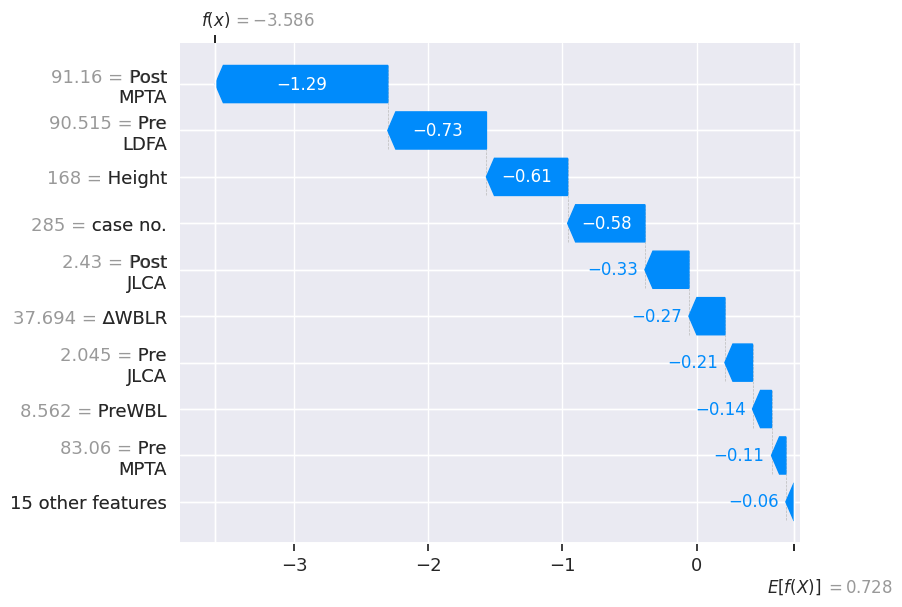

In [65]:
shap.plots.waterfall(shap_values[0])

### Force plot

In [66]:
shap_values[0]

.values =
array([-0.575972  , -0.14170486, -0.20577239, -0.1068466 , -0.7349345 ,
        0.08340627, -0.01764998, -0.3279152 , -1.2851893 , -0.09797094,
       -0.04576597, -0.26814735, -0.00214067, -0.08537838,  0.03107214,
        0.03086742,  0.02391273,  0.01783537,  0.00928217,  0.        ,
        0.06269937, -0.60522246, -0.04443007, -0.0283564 ], dtype=float32)

.base_values =
0.7280419

.data =
array([285.        ,   8.56192729,   2.045     ,  83.06      ,
        90.515     ,   7.99      ,  46.25603763,   2.43      ,
        91.16      ,  89.155     ,   6.53      ,  37.69411035,
         0.385     ,   8.1       ,  -1.36      ,  -1.46      ,
         7.71      ,   5.6       ,   2.11      ,   1.        ,
        43.        , 168.        ,  82.        ,  29.05      ])

In [67]:
shap.initjs()
shap.plots.force(shap_values[0])